In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
import sys
sys.path.append('..')
import projector.ct_projector_cupy as ct_projector
import projector.ct_projector as numpy_projector

In [3]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis, ...]
img = img[:, ::-1, ...]
spacing = np.array(spacing[::-1])

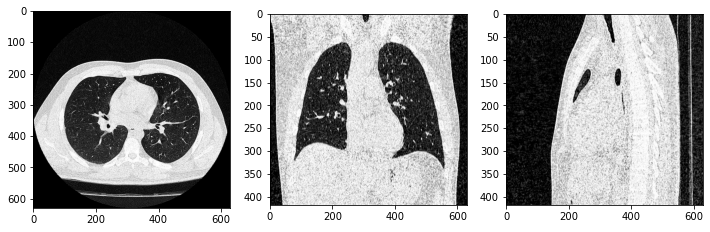

In [4]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...], 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [5]:
# setup the projector
projector = ct_projector.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = 1
projector.nv = 1
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 2304
nu = 736
nv = 1
nx = 630
ny = 630
nz = 1
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x2aaca1cffb80>


In [10]:
# very important: make sure that the arrays are saved in C order
cp.cuda.Device(0).use()

angles = projector.get_angles()
origin_img = img[0, [img.shape[1]//3, img.shape[1]//2, img.shape[1]//3*2], ...]
origin_img = origin_img[:, np.newaxis, ...]
cuimg = cp.array(origin_img, cp.float32, order = 'C')
cuangles = cp.array(angles, cp.float32, order = 'C')

projector.set_projector(projector.distance_driven_fan_fp, angles = cuangles)

In [11]:
# set which device to use
projector.set_device(0)
# forward projection
cufp = projector.fp2(cuimg, angles = cuangles)

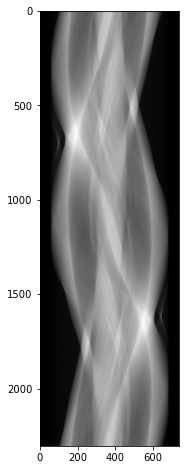

In [28]:
# show the projections
fp = cufp.get()
plt.figure(figsize = (8,8))
plt.imshow(fp[1,:, 0, :], 'gray')

In [16]:
fbp_projector = numpy_projector.ct_projector()
fbp_projector.from_file('./projector_fan.cfg')
fbp_projector.nx = img.shape[3]
fbp_projector.ny = img.shape[2]
fbp_projector.nz = 1
fbp_projector.nv = 1
fbp_projector.dx = spacing[2]
fbp_projector.dy = spacing[1]
fbp_projector.dz = spacing[0]

In [20]:
fprj = fbp_projector.ramp_filter(fp, filter_type='RL')
recon = fbp_projector.fbp_fan_bp(fprj, angles)

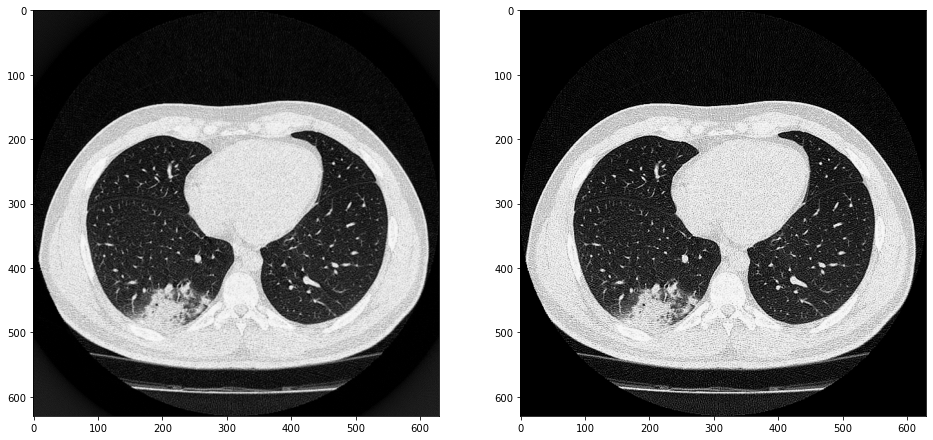

In [23]:
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(recon[2,0, :, :], 'gray', vmin=0, vmax=0.0225)
plt.subplot(122); plt.imshow(cuimg.get()[2,0, :, :], 'gray', vmin=0, vmax=0.0225)

In [24]:
projector.set_backprojector(projector.distance_driven_fan_bp, angles=cuangles, is_fbp=True)
cufprj = cp.array(fprj, cp.float32, order = 'C')
curecon = projector.bp(cufprj)

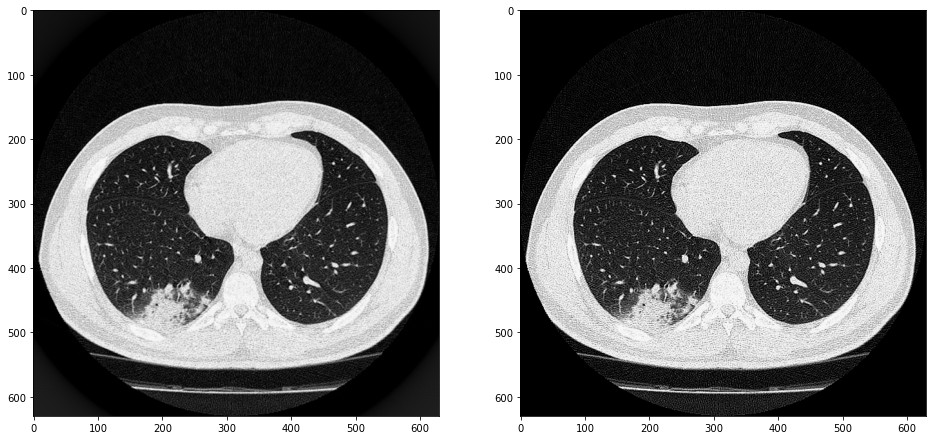

In [27]:
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(curecon.get()[2,0, :, :], 'gray', vmin=0, vmax=0.0225)
plt.subplot(122); plt.imshow(cuimg.get()[2,0, :, :], 'gray', vmin=0, vmax=0.0225)